# Data Exploration

## Summary
- There appears to be weak linear correlation between many of the features and the target to predict (MedHouseVal)
- Coordinate data appears to contain the most useful information. Can try to enhance this by:
  - Proximity to a major city
  - Proximity to the coast
  - Clustering
- Other things to try:
  - Augment data by combining features
  - Collect more housing data

## Contents
- [Kaggle Data](#kaggle-data)
  - [Initial Exploration](#initial-exploration)
  - [Feature Correlation](#feature-correlation)
  - [Feature Distributions](#feature-distributions)
  - [Plot House Values on the Map](#plot-house-values-on-the-map)
  - [Add Feature Combinations](#add-feature-combinations)
  - [Clustering](#clustering)
- [Get More Data](#get-more-data)
  - [Initial Exploration](#initial-exploration-2)
  - [Plot Features](#plot-features)
  - [Plot Map](#plot-map)
  - [Conclusions](#conclusions)
- [Distance to Points of Interest](#distance-to-points-of-interest)
  - [Distance to Coastline](#distance-to-coastline)
  - [Distance to Cites](#distance-to-cities)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

## Kaggle Data

In [2]:
train = pd.read_csv('data\\train.csv')
train.set_index('id', inplace=True)
train.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
id                                                                          
0   2.3859      15.0  3.827160   1.112100      1280.0  2.486989     34.60   
1   3.7188      17.0  6.013373   1.054217      1504.0  3.813084     38.69   
2   4.7750      27.0  6.535604   1.103175      1061.0  2.464602     34.71   
3   2.4138      16.0  3.350203   0.965432      1255.0  2.089286     32.66   
4   3.7500      52.0  4.284404   1.069246      1793.0  1.604790     37.80   

    Longitude  MedHouseVal  
id                          
0     -120.12        0.980  
1     -121.22        0.946  
2     -120.45        1.576  
3     -117.09        1.336  
4     -122.41        4.500

### Initial Exploration

In [3]:
train.describe()

MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  37137.000000  37137.000000  37137.000000  37137.000000  37137.000000   
mean       3.851029     26.057005      5.163124      1.062204   1660.778919   
std        1.803167     12.158221      1.206242      0.096490   1302.469608   
min        0.499900      2.000000      0.851064      0.500000      3.000000   
25%        2.602300     17.000000      4.357522      1.020305    952.000000   
50%        3.515600     25.000000      5.068611      1.054545   1383.000000   
75%        4.699700     35.000000      5.858597      1.088825   1856.000000   
max       15.000100     52.000000     28.837607      5.873181  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  37137.000000  37137.000000  37137.000000  37137.000000  
mean       2.831243     35.570030   -119.554329      2.079751  
std        2.702413      2.083179      1.974028      1.158571  
min        0.950000     32.550000   -124.350000      0.149990  
25%        2.394495     33.930000   -121.800000      1.208000  
50%        2.744828     34.190000   -118.450000      1.808000  
75%        3.125313     37.700000   -118.020000      2.660000  
max      502.990610     41.950000   -114.550000      5.000010

In [4]:
train.shape

(37137, 9)

---

### Feature Correlation

In [5]:
def plot_features(df: pd.DataFrame, against='MedHouseVal'):
    cols = np.array(df.columns).reshape([-1, 3])
    fig, axs = plt.subplots(*cols.shape)
    fig.set_figwidth(15)
    fig.set_figheight(20)

    for i, col_double in enumerate(cols):
        for j in range(cols.shape[1]):
            axs[i, j].set_title(cols[i, j])
            axs[i, j].plot(df[col_double[j]], df['MedHouseVal'], '.', alpha=0.3)

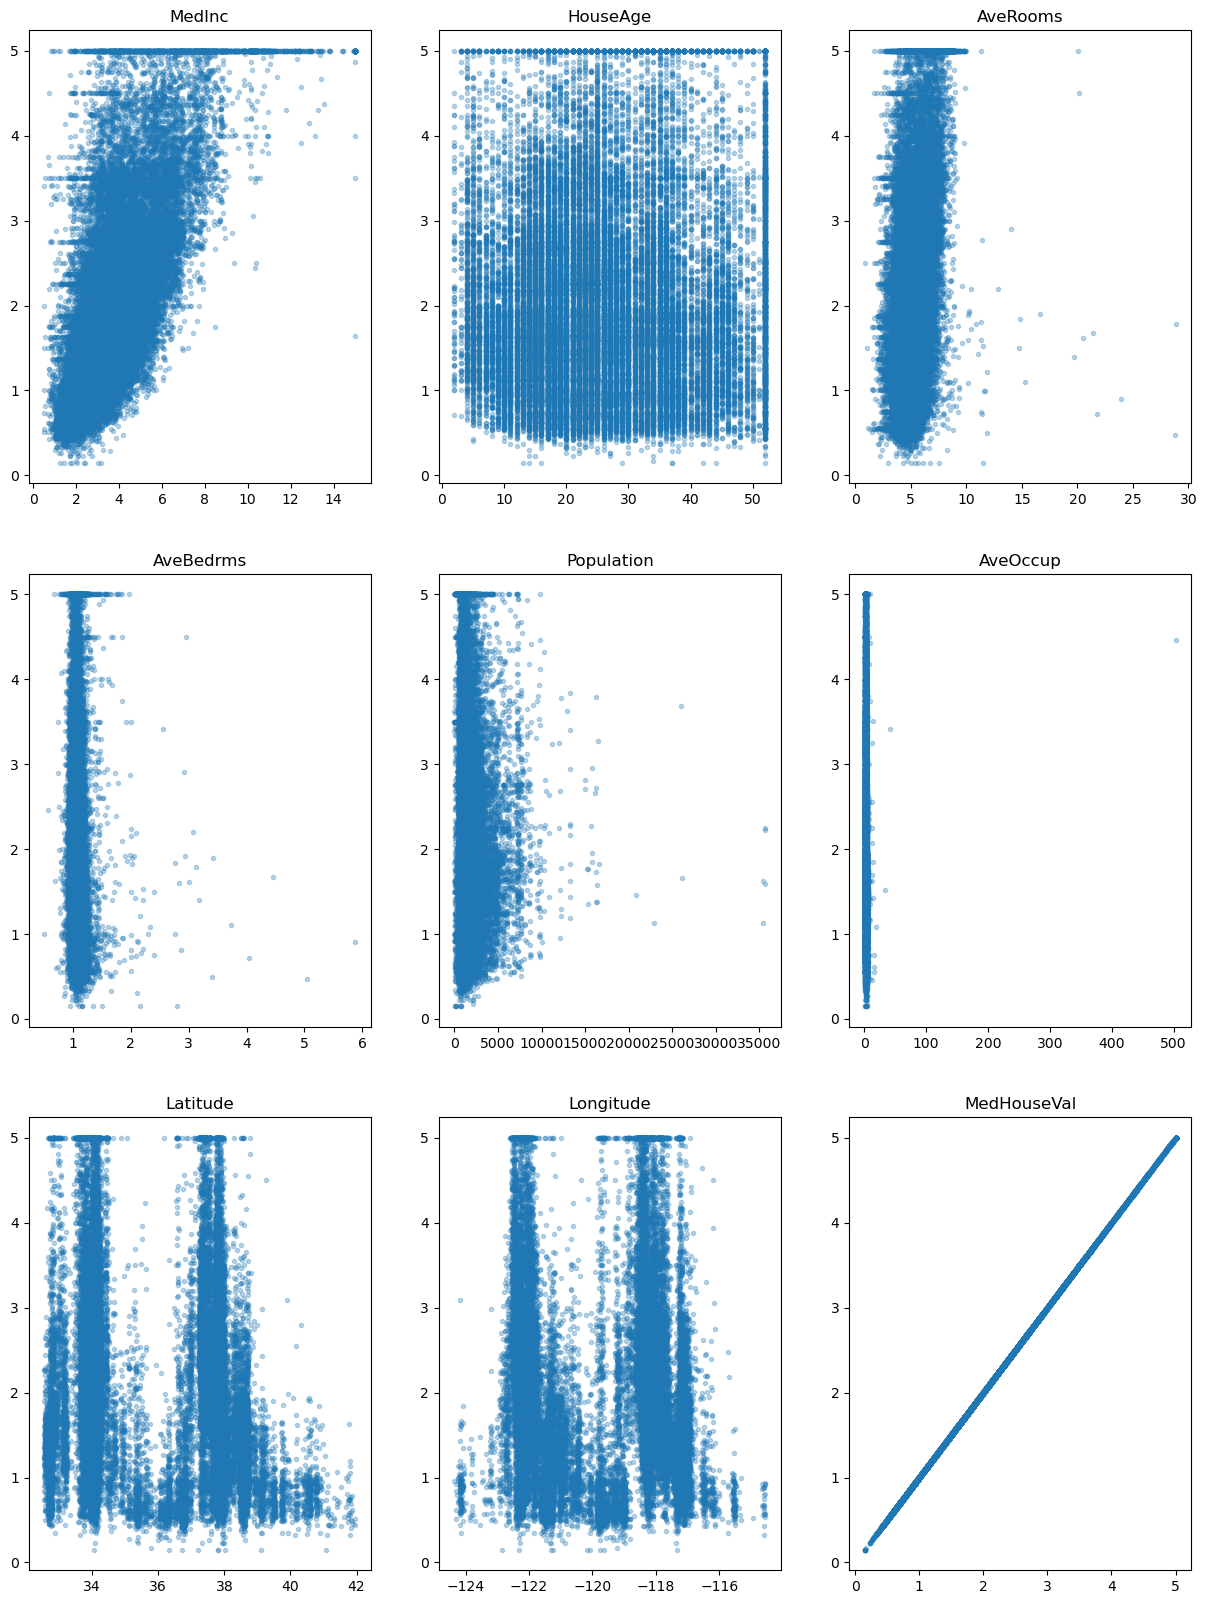

In [6]:
plot_features(train)

In [7]:
corr_matrix = train.corr()
corr_matrix['MedHouseVal'].sort_values(ascending=False)

MedHouseVal    1.000000
MedInc         0.701925
AveRooms       0.366727
HouseAge       0.103210
Population    -0.038479
AveOccup      -0.048475
Longitude     -0.056742
AveBedrms     -0.067487
Latitude      -0.116499
Name: MedHouseVal, dtype: float64

#### Observations
- Median income has a high linear correlation with median house value
- Most features have weak linear correlation with median house value
- Some features have horizontal line artifacts (e.g. median income) which means that there's a high variation in x for a given house value
- AveOccup has an outlier at 500 persons in one house!

---

### Feature Distributions

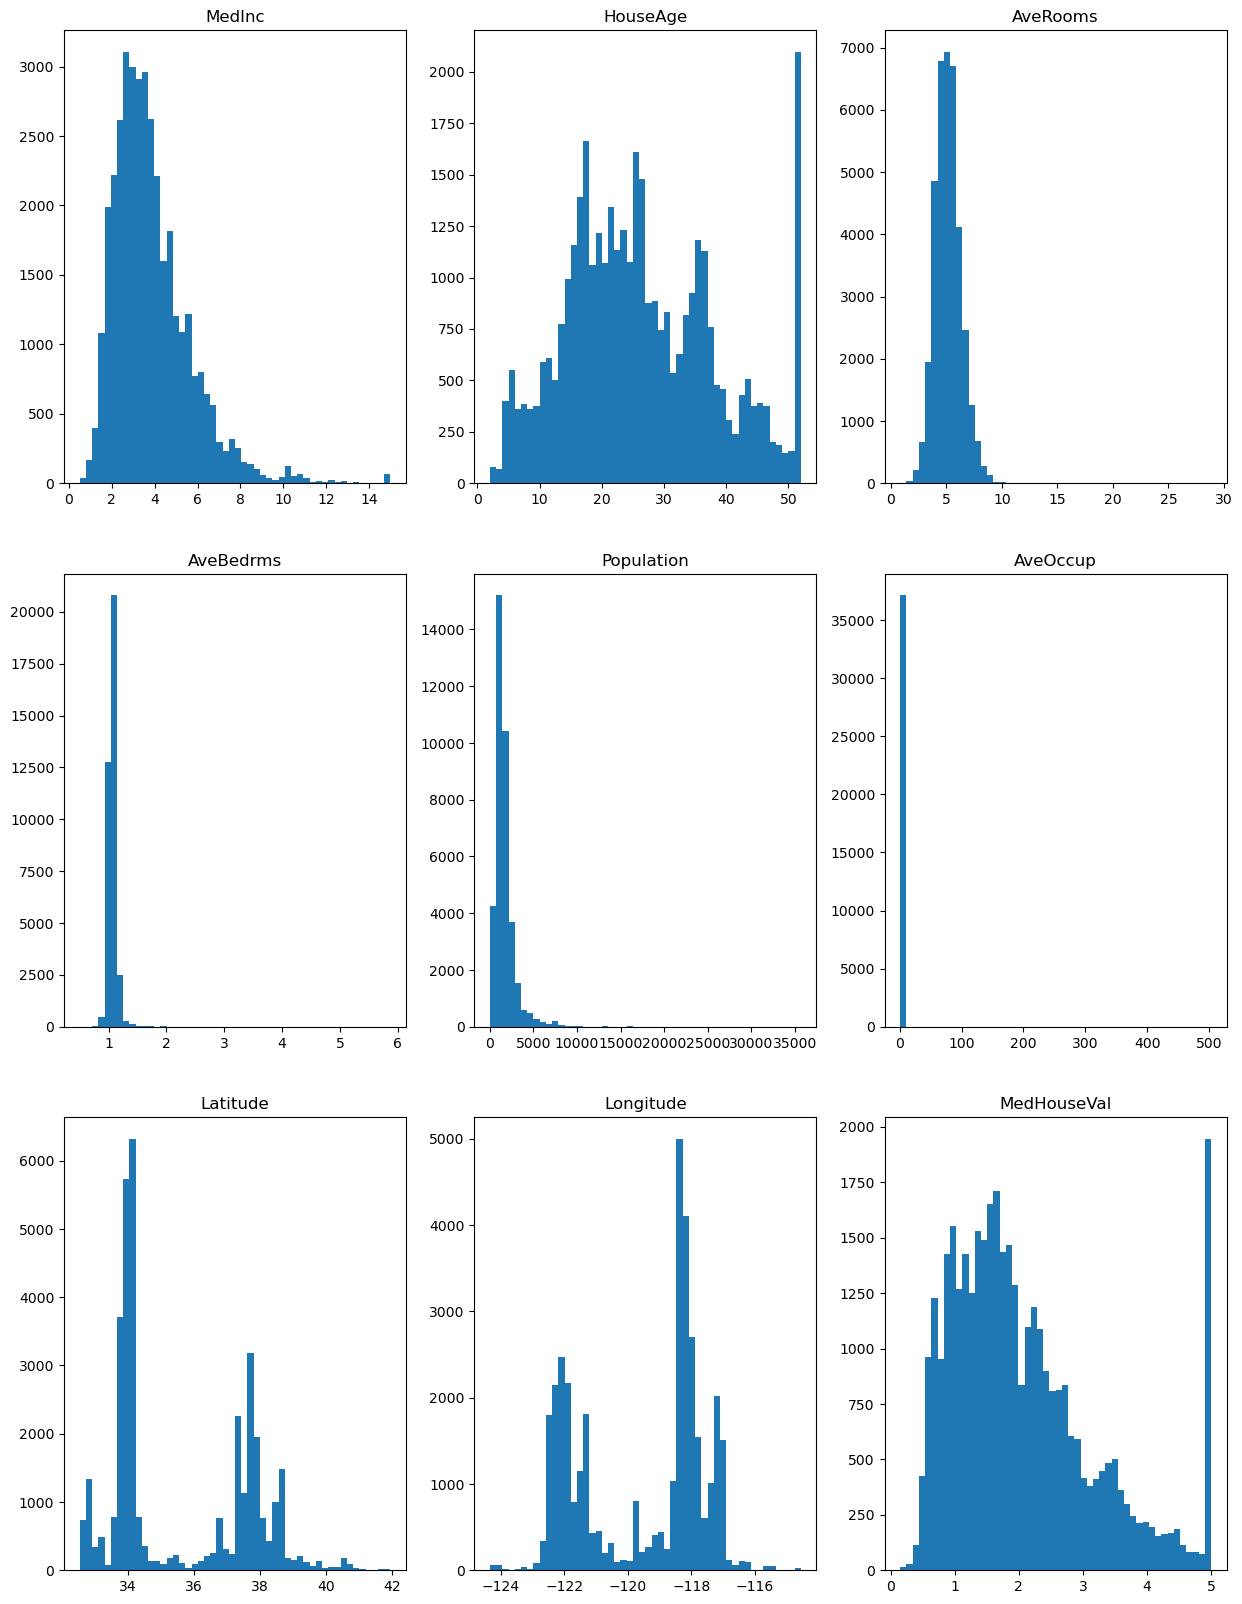

In [8]:
cols = np.array(train.columns).reshape([-1, 3])
fig, axs = plt.subplots(*cols.shape)
fig.set_figwidth(15)
fig.set_figheight(20)

for i, col_double in enumerate(cols):
    for j in range(cols.shape[1]):
        axs[i, j].set_title(cols[i, j])
        axs[i, j].hist(train[col_double[j]], bins=50)


#### Observations
- HouseAge and MedHouseVal have spikes at the top end of their range
- The distribution of MedInc and Population appears to peak early and then tail off whereas AveRooms and AveBedrms are more symmetrical
- AveOccup is generally between 1 and 3 but there is an outlier at about 500 (see [Feature Correlation](#feature-correlation) section)
- Longitude and Latitude each have 2 peaks. Each peak in one has another of similar size in the other (this suggests high density urban area in two places which is also shown in the next section)

---

### Plot House Values on the Map

In [9]:
def plot_map(df: pd.DataFrame, column_name: str, cmap='viridis'):
    with Image.open('img\\map.png') as img:
        # set figure size
        fig = plt.figure()
        fig.set_figwidth(10)
        fig.set_figheight(10)
        
        # plot image
        plt.imshow(img)
        width, height = img.size
        
        # scale data to image
        lon_scale = df['Longitude'] - df['Longitude'].min()
        lon_scale = (lon_scale * width) / lon_scale.max()
        # scale in reverse because (0,0) is top-left for images
        lat_scale = df['Latitude'] - df['Latitude'].max()
        lat_scale = (lat_scale * height) / lat_scale.min()
        
        # plot data
        plt.scatter(lon_scale, lat_scale, c=df[column_name], marker='.', alpha=0.5, cmap=cmap)
        
        # format axes
        fig.axes[0].get_xaxis().set_ticks([0, width], labels=[df['Longitude'].min(), df['Longitude'].max()])
        fig.axes[0].get_yaxis().set_ticks([0, height], labels=[df['Latitude'].max(), df['Latitude'].min()])
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        
        # add colorbar
        plt.colorbar()

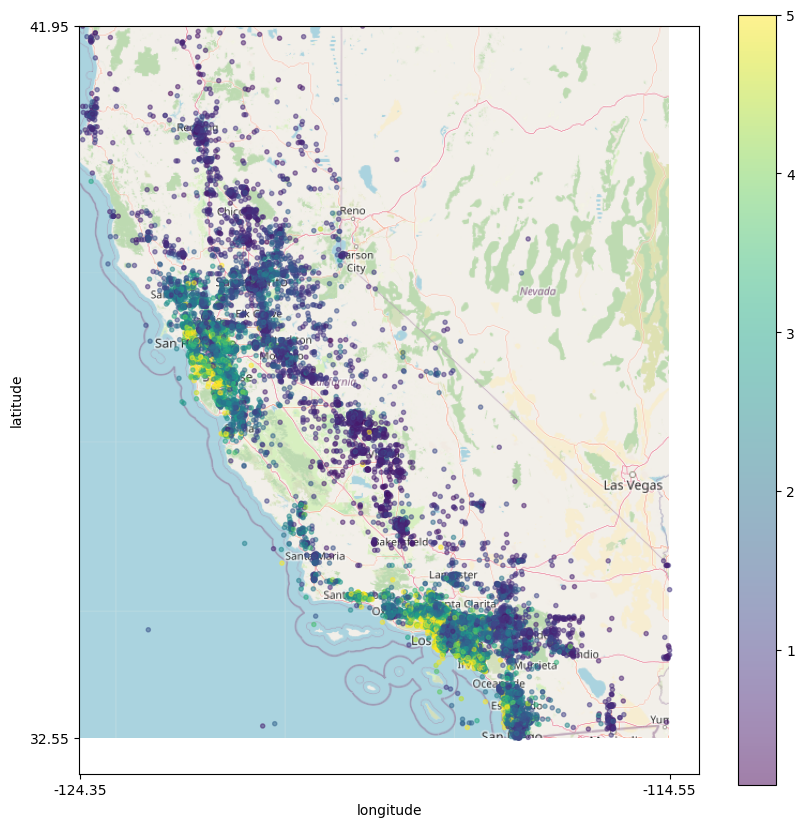

In [10]:

plot_map(train, 'MedHouseVal')

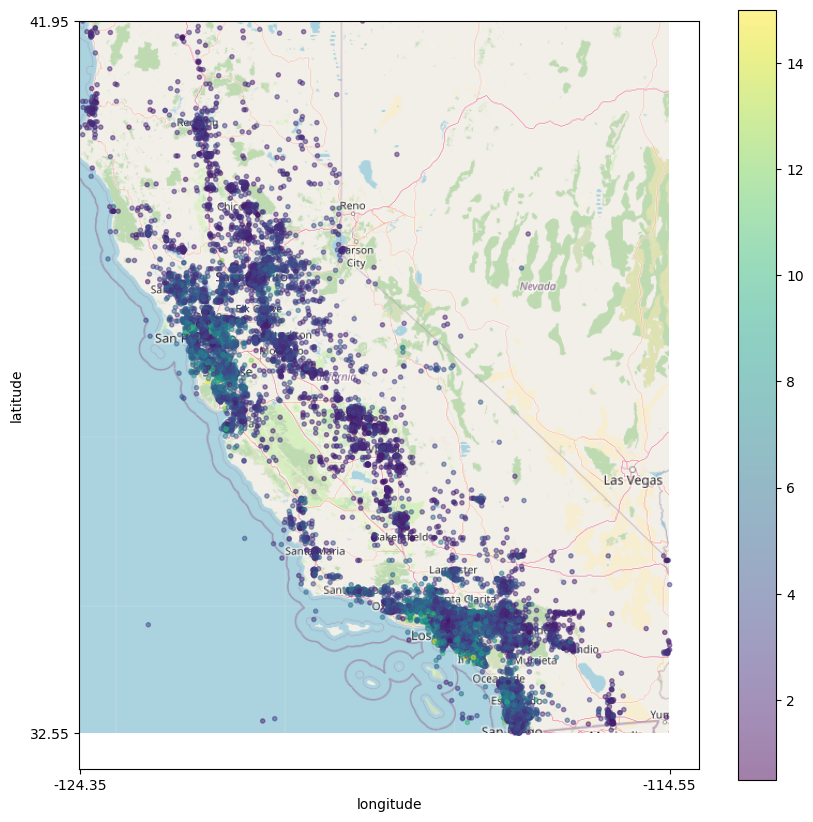

In [11]:
plot_map(train, 'MedInc')

#### Observations
- The houses with the highest median value are clustered around San Francisco, San Hose and Los Angeles
- Median house value tends to be higher near the coast and decrease the further inland they are
- The highest and lowest median house values seem as though they could be split by a straight line from North-West to South-East
- It is odd how many data points appear to be in the ocean...

---

### Add Feature Combinations
- This is to see if we can create any new informative features for the model to use

In [12]:
train_add = pd.read_csv('data\\train.csv')
train_add.set_index('id', inplace=True)

In [13]:
# commented out series have weak correlations
train_add['RoomsPerBedrm'] = train_add['AveRooms'] / train_add['AveBedrms']
train_add['MedIncPerPop'] = train_add['MedInc'] / train_add['Population']
# train_add['HouseAgePerPop'] = train_add['HouseAge'] / train_add['Population']
train_add['AveOccupPerRoom'] = train_add['AveOccup'] / train_add['AveRooms']
# train_add['AveOccupPerPop'] = train_add['AveOccup'] / train_add['Population']
train_add['MedIncPerRoom'] = train_add['MedInc'] / train_add['AveRooms']
train_add['MedIncPerBedrm'] = train_add['MedInc'] / train['AveBedrms']

Correlation Matrix

In [14]:
corr_matrix = train_add.corr()
corr_matrix['MedHouseVal'].sort_values(ascending=False)

MedHouseVal        1.000000
MedInc             0.701925
MedIncPerBedrm     0.687513
MedIncPerRoom      0.676037
RoomsPerBedrm      0.395650
AveRooms           0.366727
MedIncPerPop       0.112488
HouseAge           0.103210
Population        -0.038479
AveOccup          -0.048475
Longitude         -0.056742
AveBedrms         -0.067487
Latitude          -0.116499
AveOccupPerRoom   -0.184431
Name: MedHouseVal, dtype: float64

#### Thoughts
- Some of the new features have higher correlation than some of the original features:
  - hopefully, this will improve model performance
  - although it may not add much new information for a model to use

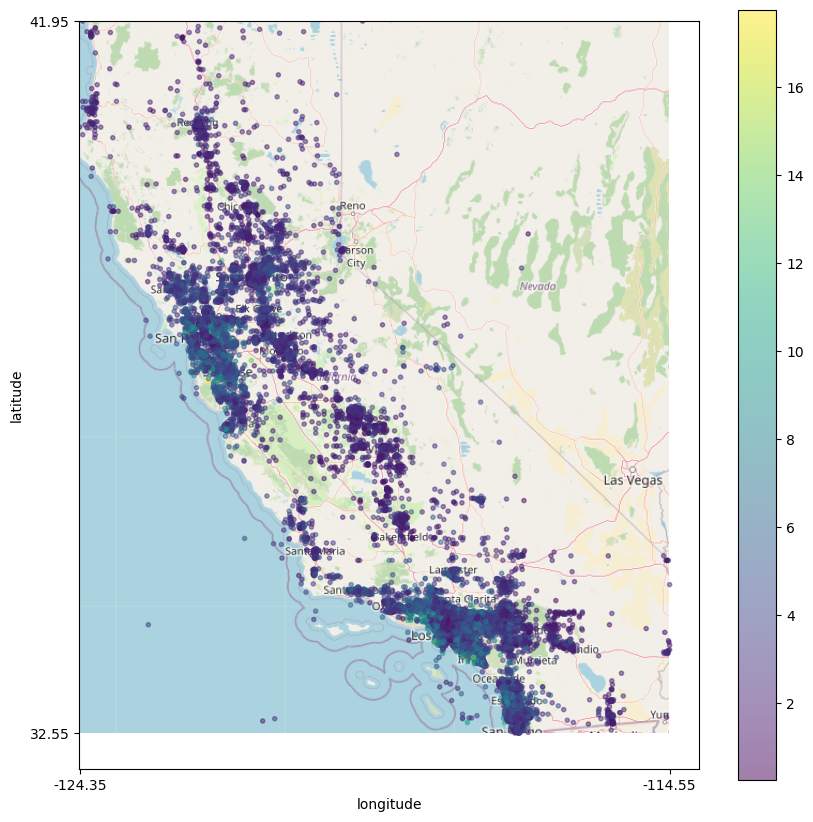

In [15]:
plot_map(train_add, 'MedIncPerBedrm')

---

### Clustering
- From [the map](#plot-house-values-on-the-map), houses of similar value seem to be located near to each other
- Finding the nearest cluster of a house may be a good indicator of its value

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [17]:
X, y = train.drop('MedHouseVal', axis=1), train['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)
X_train.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
id                                                                             
12712  0.9583       6.0  3.181818   1.000000       833.0  2.000000     34.17   
10983  4.0023      12.0  5.442424   1.050000      1141.0  2.845455     34.96   
3725   2.2544      16.0  4.158379   1.046322      4662.0  3.069982     38.70   
32554  2.7000      22.0  5.269231   1.063187      1052.0  2.859890     38.95   
16990  2.3789      26.0  2.991525   1.067797      2129.0  2.427966     34.06   

       Longitude  
id                
12712    -118.30  
10983    -120.41  
3725     -122.36  
32554    -122.63  
16990    -118.28

In [18]:
X_train.shape

(29709, 8)

In [19]:
X_train_location = X_train.loc[:, 'Latitude':'Longitude']
X_train_location.head()

Latitude  Longitude
id                        
12712     34.17    -118.30
10983     34.96    -120.41
3725      38.70    -122.36
32554     38.95    -122.63
16990     34.06    -118.28

In [20]:
kmeans = KMeans(n_clusters=25, n_init='auto')
kmeans.fit(X_train_location)

KMeans(n_clusters=25, n_init='auto')

Text(0, 0.5, 'latitude')

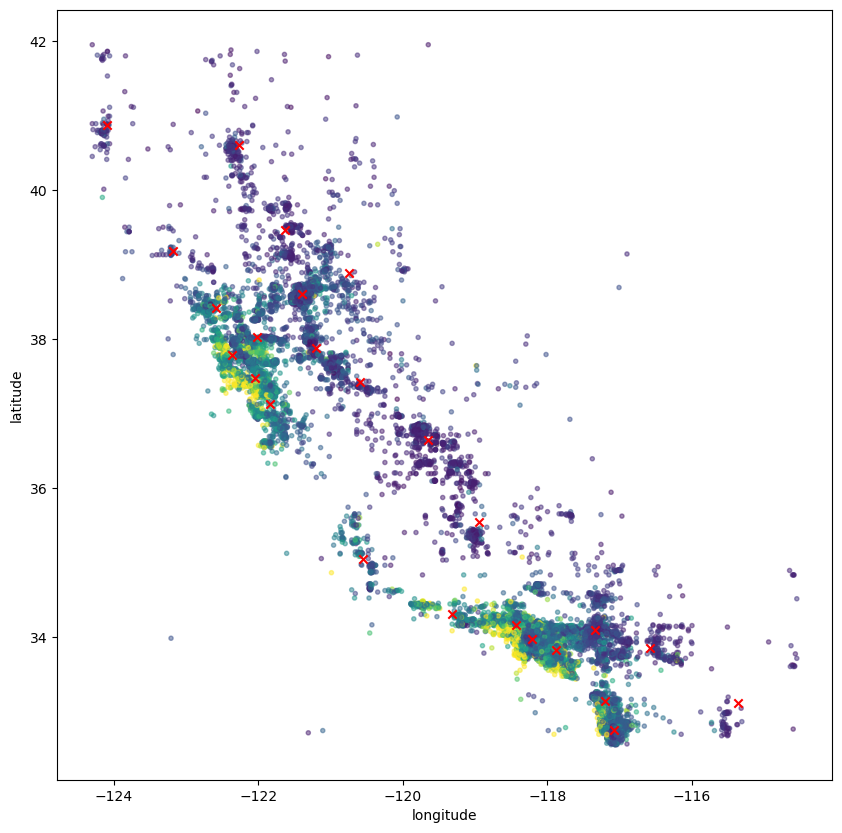

In [21]:
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
plt.scatter(X_train_location['Longitude'], X_train_location['Latitude'], c=y_train, marker='.', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], marker='x', c='#ff0000')
plt.xlabel('longitude')
plt.ylabel('latitude')

- The cluster locations appear to be fairly similar on successive runs

In [22]:
# Add cluster locations to training data
predictions = kmeans.predict(X_train_location)
centers = np.array([kmeans.cluster_centers_[pred] for pred in predictions])
X_train['ClusterLabel'] = predictions
X_train['NearestClustLat'] = centers[:, 0]
X_train['NearestClustLon'] = centers[:, 1]
X_train.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
id                                                                             
12712  0.9583       6.0  3.181818   1.000000       833.0  2.000000     34.17   
10983  4.0023      12.0  5.442424   1.050000      1141.0  2.845455     34.96   
3725   2.2544      16.0  4.158379   1.046322      4662.0  3.069982     38.70   
32554  2.7000      22.0  5.269231   1.063187      1052.0  2.859890     38.95   
16990  2.3789      26.0  2.991525   1.067797      2129.0  2.427966     34.06   

       Longitude  ClusterLabel  NearestClustLat  NearestClustLon  
id                                                                
12712    -118.30             0        34.159149      -118.436787  
10983    -120.41            10        35.037607      -120.552308  
3725     -122.36            15        38.419550      -122.587131  
32554    -122.63            15        38.419550      -122.587131  
16990    -118.28            22        33.965059      -118.211536

Gauge how useful of a feature the clusters may be

In [23]:

df = pd.concat([X_train['ClusterLabel'], y_train], axis=1)
df.head()

ClusterLabel  MedHouseVal
id                              
12712             0        1.625
10983            10        0.979
3725             15        1.260
32554            15        0.938
16990            22        1.750

In [24]:
result = df.groupby('ClusterLabel').describe()['MedHouseVal'].sort_values(by='mean', ascending=False)
result


count      mean       std      min      25%     50%      75%  \
ClusterLabel                                                                  
0             3524.0  3.000988  1.186568  0.57500  2.08075  2.7500  3.85600   
19            2001.0  2.993529  1.117331  0.60800  2.16700  2.7330  3.69100   
24            2667.0  2.600726  1.217447  0.14999  1.63400  2.4590  3.44750   
17             457.0  2.594014  1.064661  0.50000  1.89600  2.3680  3.12500   
8             1209.0  2.486780  0.887373  0.54000  1.84100  2.3760  2.86300   
9             3151.0  2.346025  0.982295  0.37500  1.66100  2.1080  2.75000   
22            5235.0  2.089681  1.013419  0.37500  1.41550  1.7930  2.44600   
1             1015.0  2.063728  0.955446  0.55900  1.37500  1.8100  2.59600   
5              650.0  2.048710  0.945163  0.47500  1.35725  1.7855  2.48525   
15             467.0  1.944548  0.743326  0.47500  1.46950  1.8160  2.39200   
10             234.0  1.745316  0.750934  0.41300  1.20850  1.6020  2.21250   
21            1663.0  1.679622  0.814458  0.45000  1.18350  1.5020  1.88300   
4             1734.0  1.287085  0.573168  0.32500  0.88950  1.1900  1.55500   
23             236.0  1.276534  0.446014  0.47500  0.97600  1.2290  1.47975   
13            1589.0  1.270760  0.596735  0.14999  0.90000  1.1420  1.46300   
16             963.0  1.201789  0.532348  0.22500  0.85400  1.0940  1.46100   
2              321.0  1.059807  0.567431  0.42500  0.72000  0.8850  1.18800   
6              292.0  1.057212  0.437741  0.14999  0.73875  0.9520  1.30350   
7               68.0  1.054824  0.399135  0.48600  0.75675  0.9430  1.30925   
12             110.0  0.884009  0.349594  0.34400  0.67150  0.8475  0.96350   
20             232.0  0.848957  0.322942  0.14999  0.65975  0.8035  0.94525   
14             421.0  0.840663  0.280569  0.32500  0.64800  0.7820  0.94700   
3              450.0  0.794347  0.405158  0.17500  0.57450  0.7005  0.88700   
11             934.0  0.788014  0.371653  0.14999  0.57900  0.6995  0.90150   
18              86.0  0.782302  0.308707  0.32500  0.61300  0.7220  0.87500   

                  max  
ClusterLabel           
0             5.00001  
19            5.00001  
24            5.00001  
17            5.00001  
8             5.00001  
9             5.00001  
22            5.00001  
1             5.00001  
5             5.00001  
15            5.00001  
10            5.00001  
21            5.00001  
4             5.00001  
23            4.50000  
13            5.00001  
16            5.00001  
2             4.50000  
6             2.90100  
7             2.98900  
12            3.08700  
20            2.79800  
14            2.42700  
3             5.00001  
11            5.00001  
18            2.47300

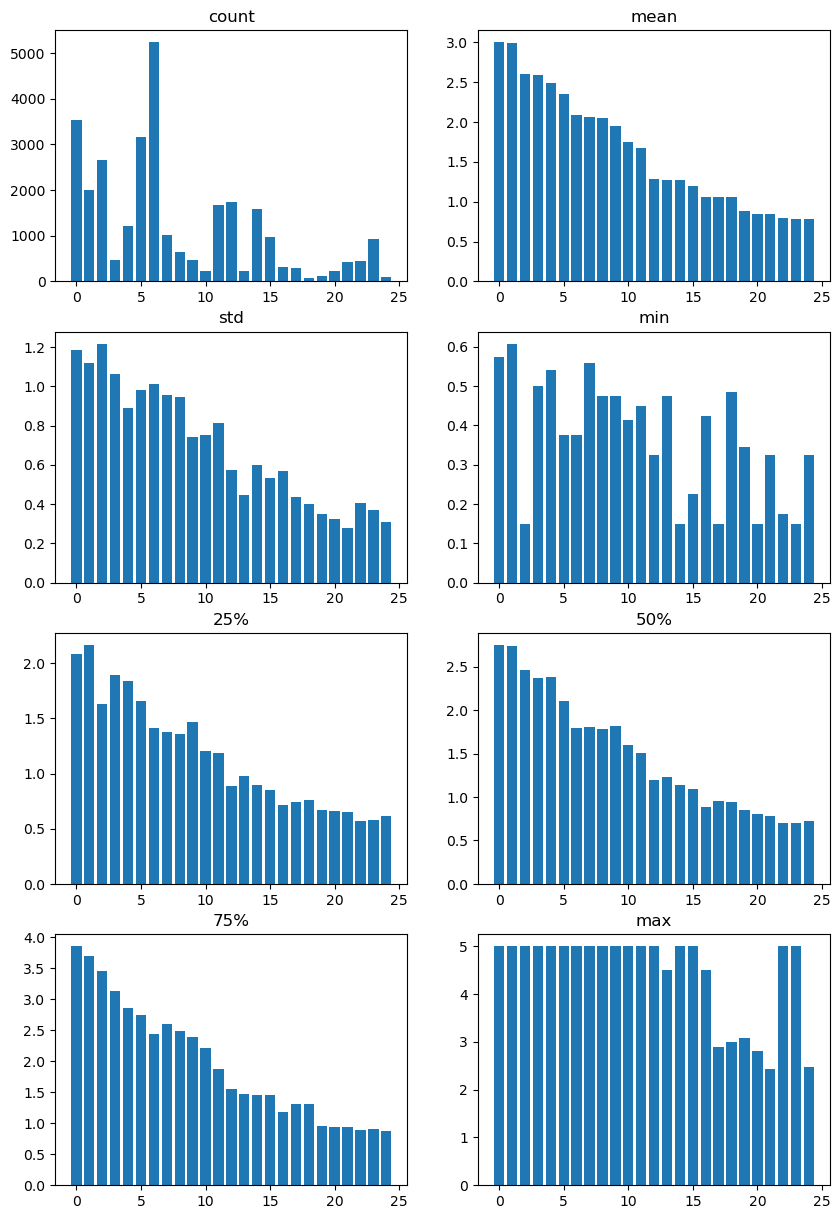

In [25]:
fig, axs = plt.subplots(4, 2)
fig.set_figwidth(10)
fig.set_figheight(15)

for i, stat in enumerate(result.columns):
    axs[i // 2, i % 2].set_title(stat)
    axs[i // 2, i % 2].bar(range(len(result[stat])), result[stat])    

#### Observations
- Looking at the mean and std graphs
  - As the mean decreases so does std 
    - so clusters that have lower mean generally have a smaller spread of MedHouseVal
    - but clusers with higher mean have a higher spread of MedHouseVal, suggesting that those cluster may be less useful for helping to predict MedHouseVal
- Will have to test the clustering to see if it helps the model's prediction

---

## Get More Data
- use sklearn's California housing dataset

In [26]:
from sklearn.datasets import fetch_california_housing

In [27]:
housing = fetch_california_housing()
data = np.concatenate([housing.data, housing.target.reshape([-1, 1])], axis=1)
columns = housing.feature_names + housing.target_names
more_data = pd.DataFrame(data, columns=columns)

### Initial Exploration <a class="anchor" id="initial-exploration-2"></a>

In [28]:
more_data.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422

In [29]:
more_data.describe()

MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.540000   -124.350000      0.149990  
25%        2.429741     33.930000   -121.800000      1.196000  
50%        2.818116     34.260000   -118.490000      1.797000  
75%        3.282261     37.710000   -118.010000      2.647250  
max     1243.333333     41.950000   -114.310000      5.000010

In [30]:
# see the how similar the two datasets are
train.describe() - more_data.describe()

MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  16497.000000  16497.000000  16497.000000  16497.000000  16497.000000   
mean      -0.019642     -2.582481     -0.265876     -0.034471    235.302175   
std       -0.096655     -0.427337     -1.267931     -0.377421    170.007486   
min        0.000000      1.000000      0.004910      0.166667      0.000000   
25%        0.038900     -1.000000     -0.083194      0.014226    165.000000   
50%       -0.019200     -4.000000     -0.160518      0.005765    217.000000   
75%       -0.043550     -2.000000     -0.193784     -0.010701    131.000000   
max        0.000000      0.000000   -113.071484    -28.193486      0.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  16497.000000  16497.000000  16497.000000  16497.000000  
mean      -0.239412     -0.061832      0.015375      0.011193  
std       -7.683637     -0.052774     -0.029504      0.004614  
min        0.257692      0.010000      0.000000      0.000000  
25%       -0.035246      0.000000      0.000000      0.012000  
50%       -0.073288     -0.070000      0.040000      0.011000  
75%       -0.156948     -0.010000     -0.010000      0.012750  
max     -740.342723      0.000000     -0.240000      0.000000

- The data seem to have similar distributions between the two datasets
- There are some outliers e.g. the max AveOccup is much higher for `more_data`

In [31]:
more_data.shape

(20640, 9)

### Plot Features

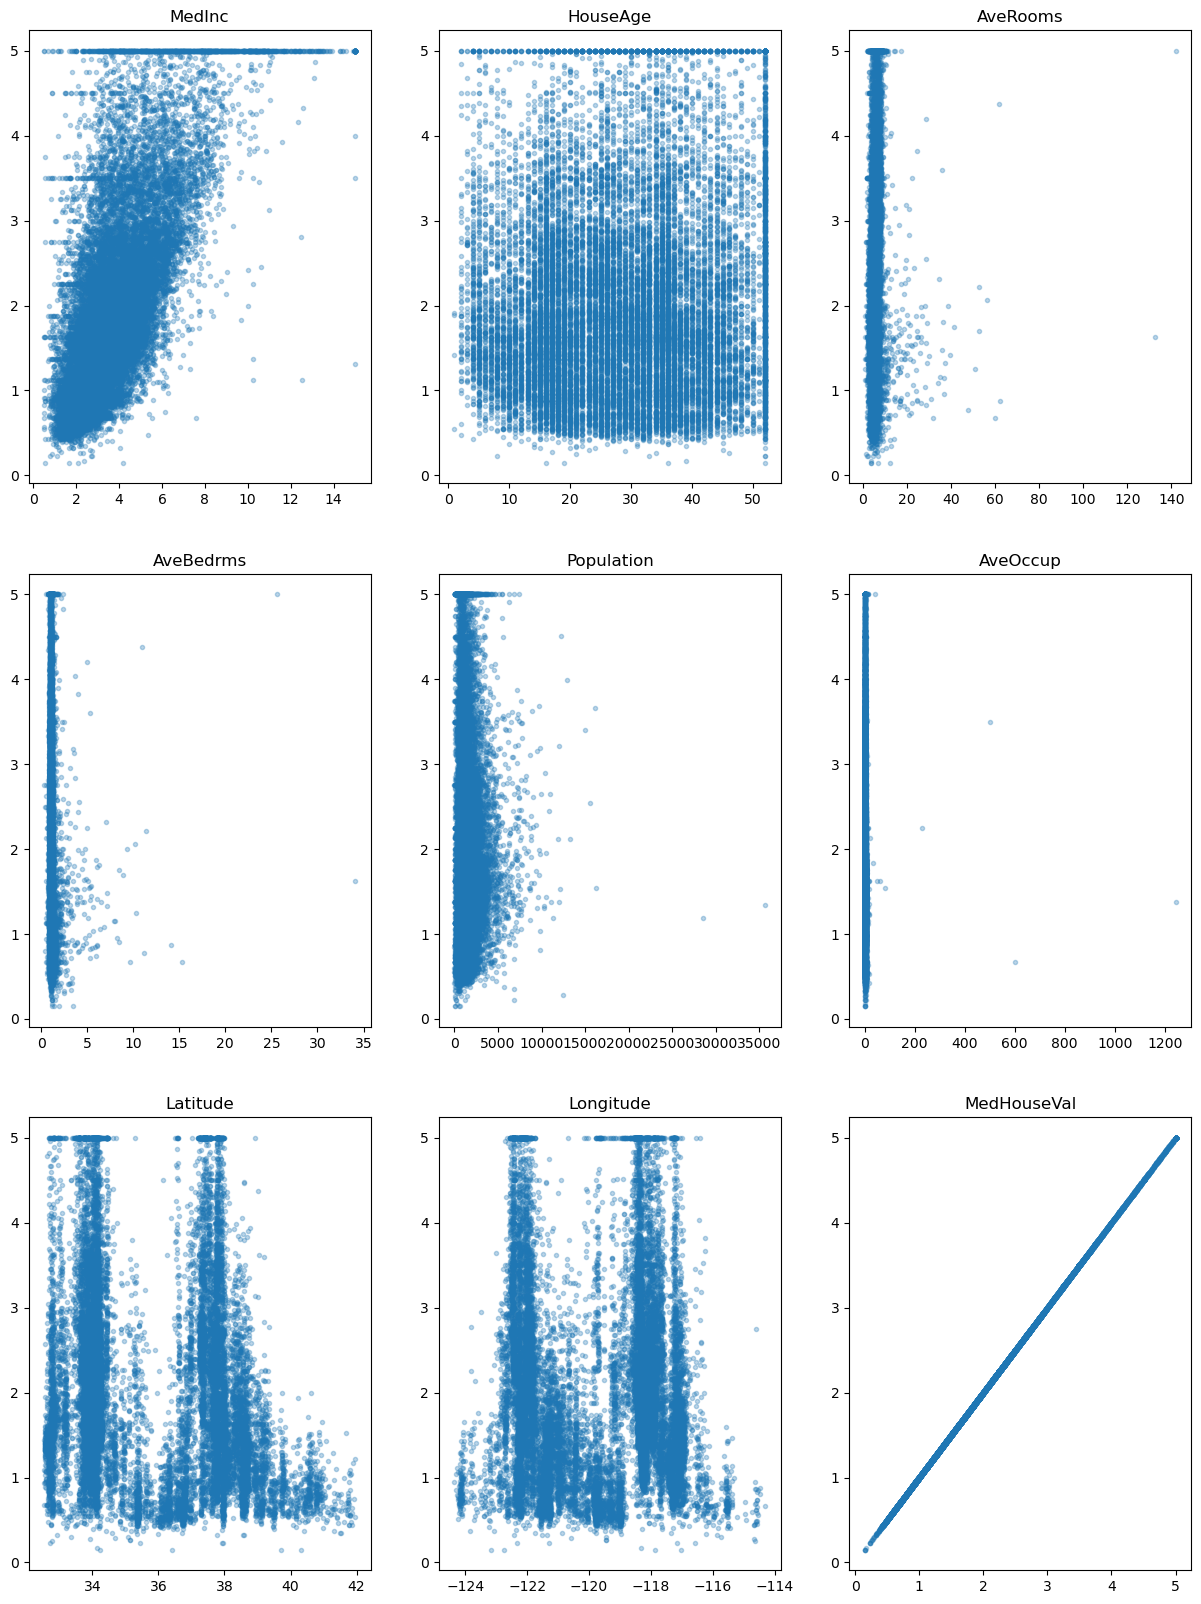

In [32]:
plot_features(more_data)

- Compared to the [Kaggle dataset](#feature-correlation), it's very similar

---

### Plot Map

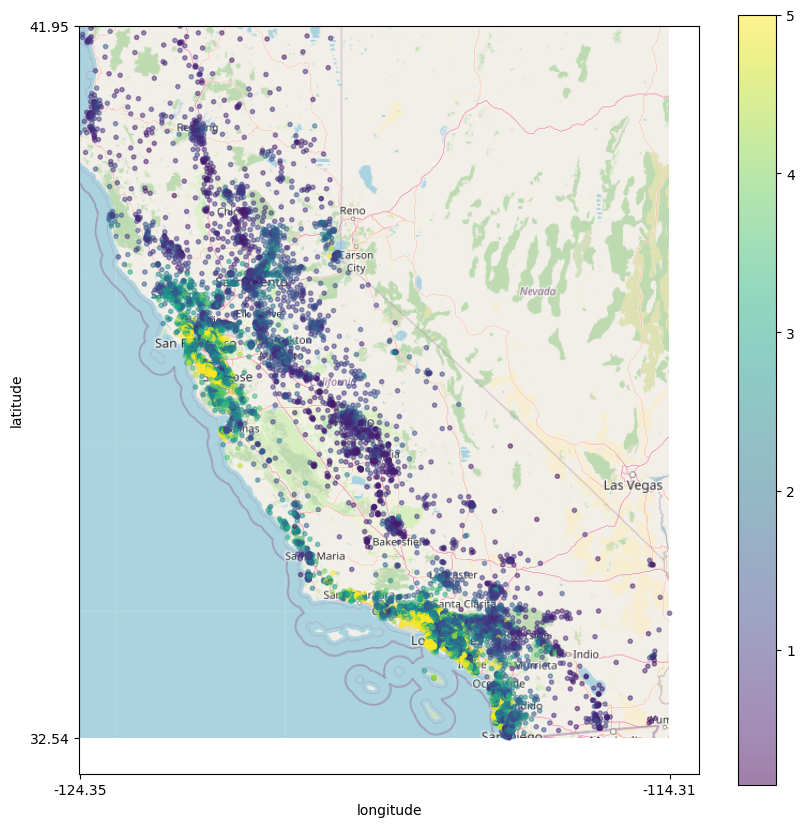

In [33]:
plot_map(more_data, 'MedHouseVal')

### Conclusions
- Append the sklearn dataset to the Kaggle one to see if that improves model performance
  - I think it is safe to do this because the distributions of the dataset are the same so testing against dev set is valid

---

## Distance to Points of Interest

## Distance to Coastline
- https://osmdata.openstreetmap.de/data/coastlines.html

In [34]:
import shapefile

In [35]:
filepath = 'data\\coastlines-split-4326\\lines.shp'
sf = shapefile.Reader(filepath)

In [36]:
bbox = [train['Longitude'].min(), train['Latitude'].min(), train['Longitude'].max(), train['Latitude'].max()]
bbox


[-124.35, 32.55, -114.55, 41.95]

In [37]:
points = []
for shape in sf.iterShapes():
    if all([shape.bbox[0] >= bbox[0],
            shape.bbox[1] >= bbox[1],
            shape.bbox[2] <= bbox[2],
            shape.bbox[3] <= bbox[3]
    ]):   
        for point in shape.points:
            points.append(point)

In [38]:
points = np.array(points)
points.shape

(169618, 2)

In [39]:
def plot_coastline(coast_points: np.array, house_locations: pd.DataFrame=None):
    with Image.open('img\\map.png') as img:
        # set figure size
        fig = plt.figure()
        fig.set_figwidth(10)
        fig.set_figheight(10)
        
        # plot image
        plt.imshow(img)
        width, height = img.size
        # approximation of where the coastline is at the bottom of the 
        # picture, for scaling the position of the coast_points
        coast_width = int(width * 0.75)
        
        # Plot Coastline #
        # scale data to image
        lon_scale = coast_points[:, 0] - np.min(coast_points[:, 0])
        lon_scale = (lon_scale * coast_width) / np.max(lon_scale)
        # scale in reverse because (0,0) is top-left for images
        lat_scale = coast_points[:, 1] - np.max(coast_points[:, 1])
        lat_scale = (lat_scale * height) / np.min(lat_scale)
        
        # plot data
        plt.scatter(lon_scale, lat_scale, c='#ff0000', marker='.')

        if house_locations is not None:
            # Plot Houses #
            # scale data to image
            lon_scale = house_locations['Longitude'] - house_locations['Longitude'].min()
            lon_scale = (lon_scale * width) / lon_scale.max()
            # scale in reverse because (0,0) is top-left for images
            lat_scale = house_locations['Latitude'] - house_locations['Latitude'].max()
            lat_scale = (lat_scale * height) / lat_scale.min()
            
            # plot data
            plt.scatter(lon_scale, lat_scale, c=house_locations['MedHouseVal'], marker='.', alpha=0.5)
        
        # format axes
        fig.axes[0].get_xaxis().set_ticks([0, width], labels=[np.min(coast_points[:, 0]), np.max(coast_points[:, 0])])
        fig.axes[0].get_yaxis().set_ticks([0, height], labels=[np.max(coast_points[:, 1]), np.min(coast_points[:, 1])])
        plt.xlabel('longitude')
        plt.ylabel('latitude')

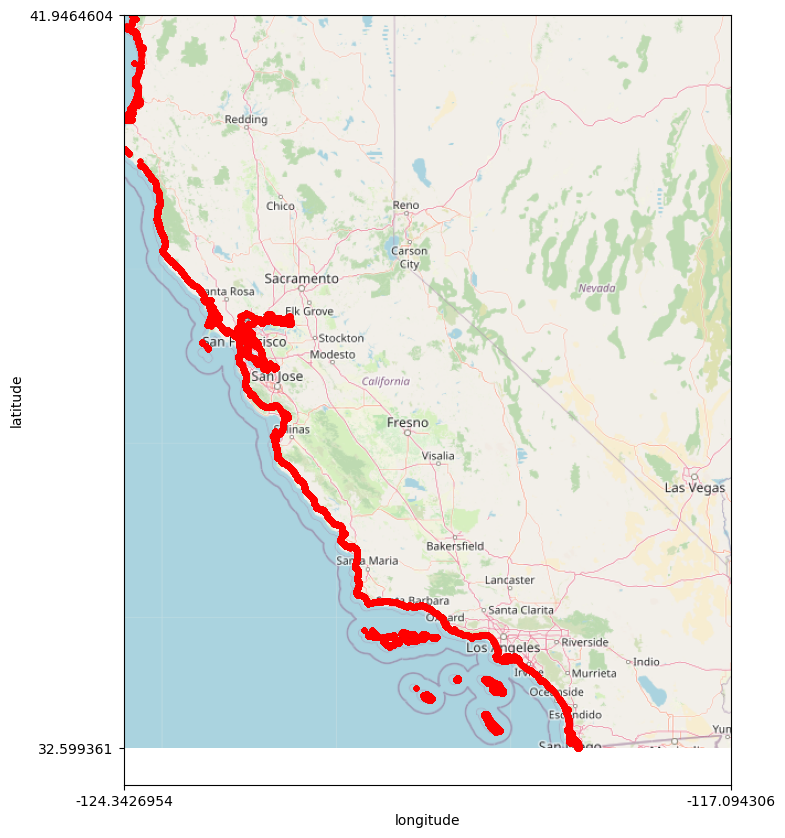

In [40]:
plot_coastline(points)

- A bit of the coast is chopped off near the top (same latitude as Redding)
- So need to regather the data with this bit of coast included
- Need to remove the points that outline the lakes in San Francisco
- Then save this data to a new file so that it can be used to find a house's distance to the coast

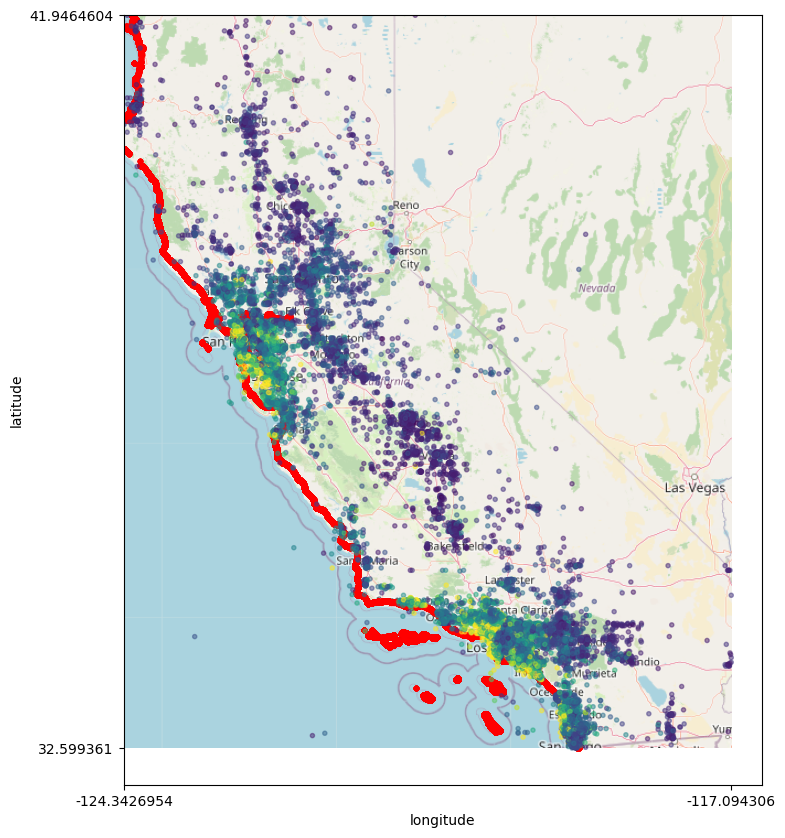

In [41]:
plot_coastline(points, house_locations=train)

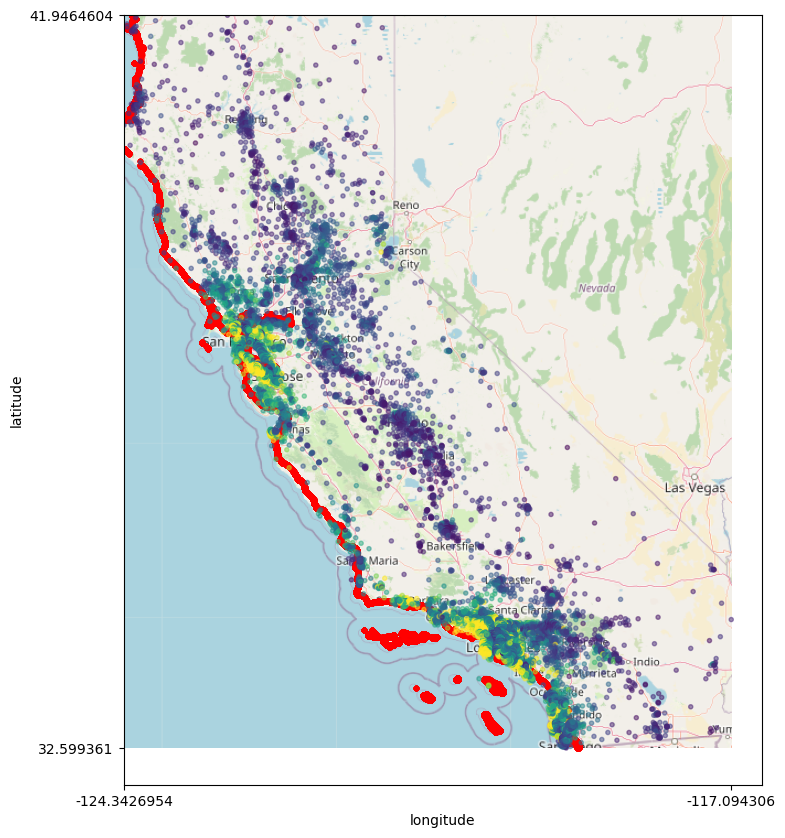

In [42]:
plot_coastline(points, house_locations=more_data)

- Image above is to check whether house prices are higher in general around the bays
- A more sophisticated map is probably needed to do this justice (rather than just overlaying onto an image)
- However, it seems

#### Remove the bay outlines

In [43]:
bbox_t = list[int]


def is_in(shape: shapefile.Shape, bboxes: list[bbox_t]) -> bool:
    for i, bbox in enumerate(bboxes):
        if all([    
            shape.bbox[0] >= bbox[0],
            shape.bbox[1] >= bbox[1],
            shape.bbox[2] <= bbox[2],
            shape.bbox[3] <= bbox[3]
        ]):
            return True
    return False


def find_coastline_coords(sf: shapefile.Reader, coast_bbox: bbox_t, exclusions: list[bbox_t]) -> np.array:
    points = []
    for shape in sf.iterShapes():
        if is_in(shape, [coast_bbox]) and not is_in(shape, exclusions):
        # if is_in(shape, exclusions):
            for point in shape.points:
                points.append(point)
    return np.array(points)

In [44]:
# bounding boxes for excluding the bays (combination of OSM and trial & error)
san_pablo_exclusion = [-122.6, 37.7, -121.5, 38.3]
san_fran_exclusion = [-122.42, 37.4, -121.8, 37.9]

# include the bit that was chopped off the original bounding box
coast_bbox = [train['Longitude'].min() - 0.2, train['Latitude'].min(), train['Longitude'].max(), train['Latitude'].max()]

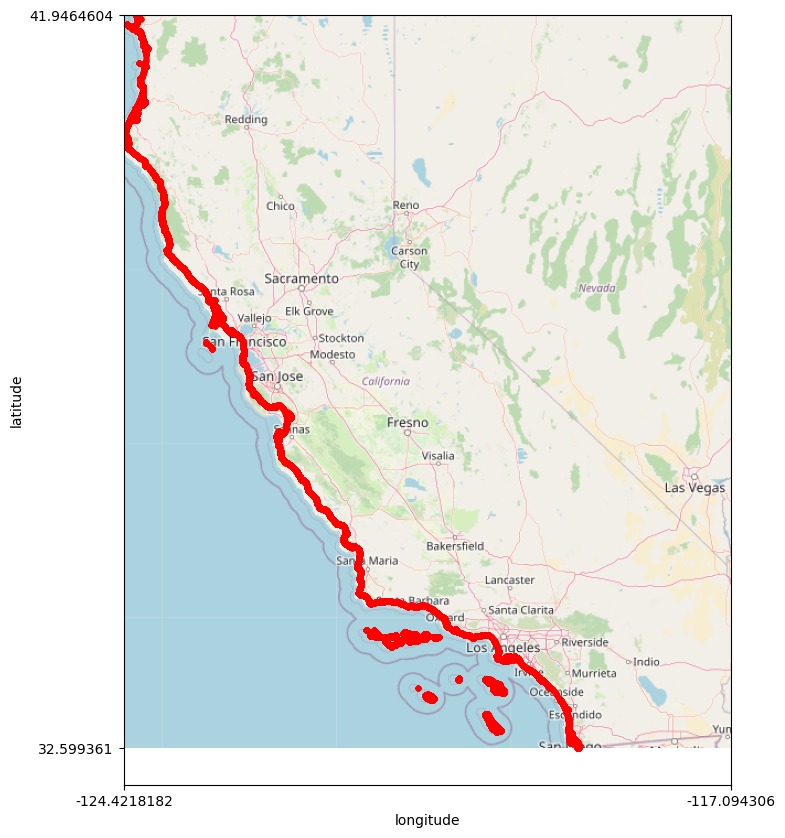

In [45]:
coast_coords = find_coastline_coords(
    sf,
    coast_bbox,
    [san_fran_exclusion, san_pablo_exclusion]
)
plot_coastline(coast_coords)

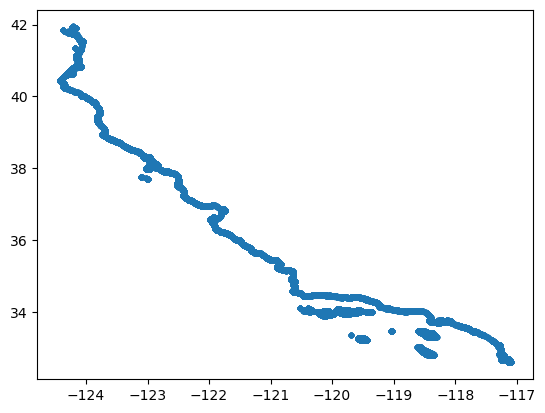

In [46]:
plt.scatter(coast_coords[:, 0], coast_coords[:, 1], marker='.')

- This looks like a reasonable coastline
- Leaving the islands on there because some of the houses appear to be on them

#### Find distance to coastline for each point

In [47]:
def calc_dist_to_coast(df: pd.DataFrame, coast_coords: np.array) -> np.array:
    length = df.shape[0]
    min_dists = np.zeros([length, 1])

    # Is there a way to parallelise this instead of looping through each entry in the df?
    # It takes a while to compute as is...
    for i in range(length):
        house_coord = df.loc[i, ['Longitude', 'Latitude']].to_numpy()
        manhattan = coast_coords - house_coord
        dist = np.linalg.norm(manhattan, ord=2, axis=1, keepdims=True)
        min_dists[i] = np.min(dist)
    
    return min_dists

min_dists = calc_dist_to_coast(train, coast_coords)

In [48]:
print(min_dists[:5])
print(min_dists.min())
print(min_dists.max())
assert min_dists.shape[0] == train.shape[0]

[[0.1276595 ]
 [1.5651918 ]
 [0.15069182]
 [0.01706718]
 [0.09016798]]
3.0486718411980356e-05
5.3591319879352355


In [49]:
train['DistToCoast'] = min_dists

In [50]:
train.describe()

MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  37137.000000  37137.000000  37137.000000  37137.000000  37137.000000   
mean       3.851029     26.057005      5.163124      1.062204   1660.778919   
std        1.803167     12.158221      1.206242      0.096490   1302.469608   
min        0.499900      2.000000      0.851064      0.500000      3.000000   
25%        2.602300     17.000000      4.357522      1.020305    952.000000   
50%        3.515600     25.000000      5.068611      1.054545   1383.000000   
75%        4.699700     35.000000      5.858597      1.088825   1856.000000   
max       15.000100     52.000000     28.837607      5.873181  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal   DistToCoast  
count  37137.000000  37137.000000  37137.000000  37137.000000  37137.000000  
mean       2.831243     35.570030   -119.554329      2.079751      0.474687  
std        2.702413      2.083179      1.974028      1.158571      0.537903  
min        0.950000     32.550000   -124.350000      0.149990      0.000030  
25%        2.394495     33.930000   -121.800000      1.208000      0.113419  
50%        2.744828     34.190000   -118.450000      1.808000      0.252020  
75%        3.125313     37.700000   -118.020000      2.660000      0.597550  
max      502.990610     41.950000   -114.550000      5.000010      5.359132

In [51]:
train.corrwith(train['MedHouseVal']).sort_values(ascending=False)

MedHouseVal    1.000000
MedInc         0.701925
AveRooms       0.366727
HouseAge       0.103210
Population    -0.038479
AveOccup      -0.048475
Longitude     -0.056742
AveBedrms     -0.067487
Latitude      -0.116499
DistToCoast   -0.468807
dtype: float64

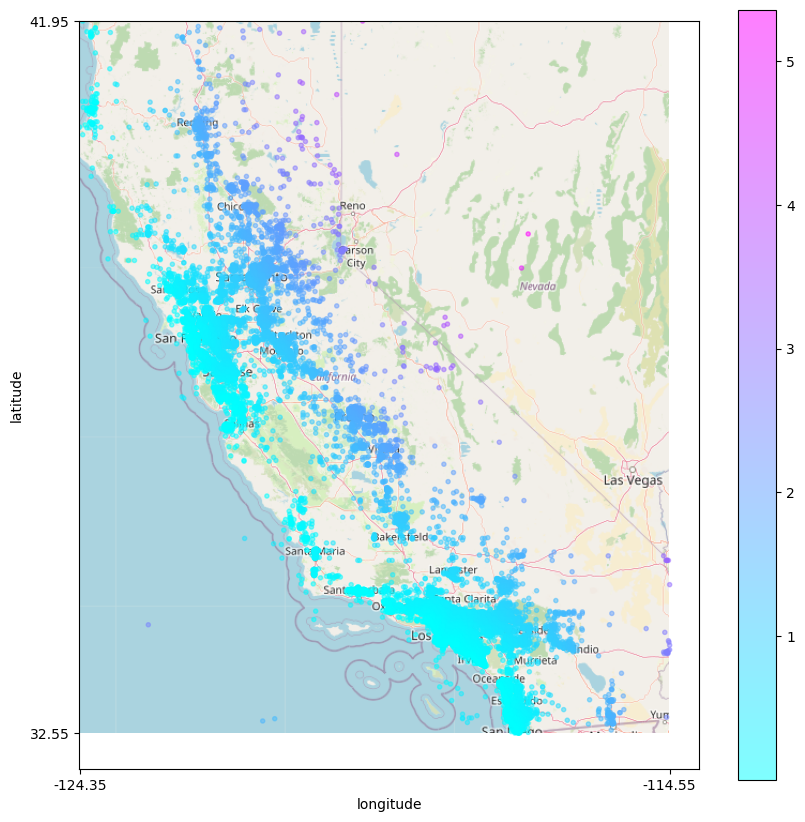

In [52]:
plot_map(train, 'DistToCoast', cmap='cool') # use `cool` cmap since the range of colours all show up well on this map

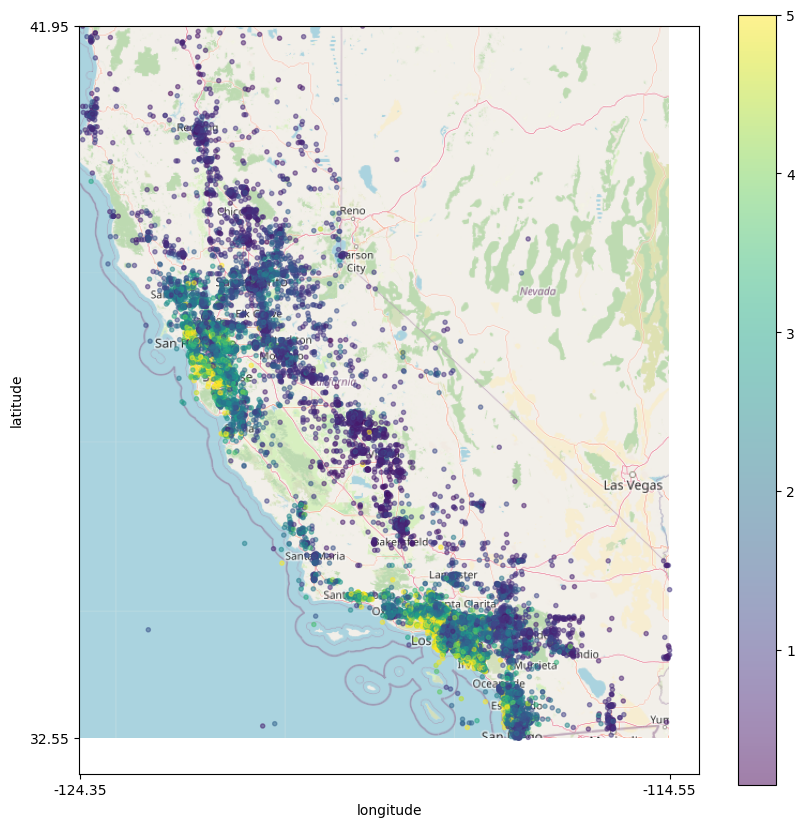

In [53]:
plot_map(train, 'MedHouseVal')

- The map indicates that the calculation of distance to coast is reasonable

Text(0.5, 0, 'DistToCoast')

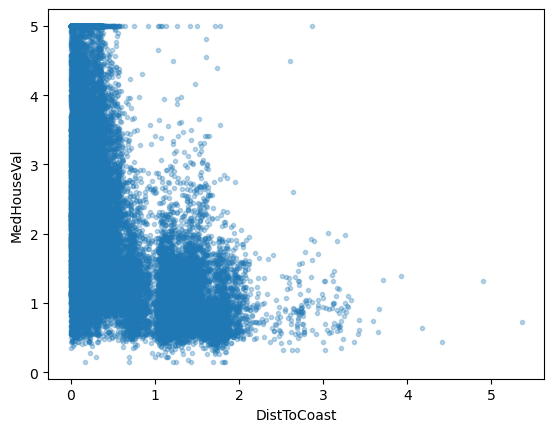

In [54]:
plt.scatter(train['DistToCoast'], train['MedHouseVal'], marker='.', alpha=0.3)
plt.ylabel('MedHouseVal')
plt.xlabel('DistToCoast')

- From the graph, there is a reasonable negative linear correaltion:
  - Houses further away than 1 degree rarely have a value above 3
  - The highest value houses are mostly < 1 degree from the coast
  - However, there is still a large spread (the full range) of values for houses < 1 degree from the coast
- There is still useful information in this feature

## Distance to Cities

In [55]:
def dist_to_coord(df: pd.DataFrame, coord: np.array) -> np.array:
    house_coord = df.loc[:, ['Longitude', 'Latitude']].to_numpy()
    manhattan = house_coord - np.expand_dims(coord, axis=0)
    return np.linalg.norm(manhattan, ord=2, axis=1, keepdims=True)


In [56]:
san_fran_coord = np.array([-122.431297, 37.773972])
los_angeles_coord = np.array([-118.243683, 34.052235])

In [57]:
# https://www.latlong.net
dist_to_san_fran = dist_to_coord(train, san_fran_coord)
dist_to_los_angeles = dist_to_coord(train, los_angeles_coord)


In [58]:
train['DistToSanFrancisco'] = dist_to_san_fran
train['DistToLA'] = dist_to_los_angeles


In [59]:
train.corrwith(train['MedHouseVal']).sort_values(ascending=False)

MedHouseVal           1.000000
MedInc                0.701925
AveRooms              0.366727
HouseAge              0.103210
Population           -0.038479
DistToSanFrancisco   -0.042158
AveOccup             -0.048475
Longitude            -0.056742
AveBedrms            -0.067487
DistToLA             -0.104989
Latitude             -0.116499
DistToCoast          -0.468807
dtype: float64

Text(0.5, 0, 'DistToSanFrancisco')

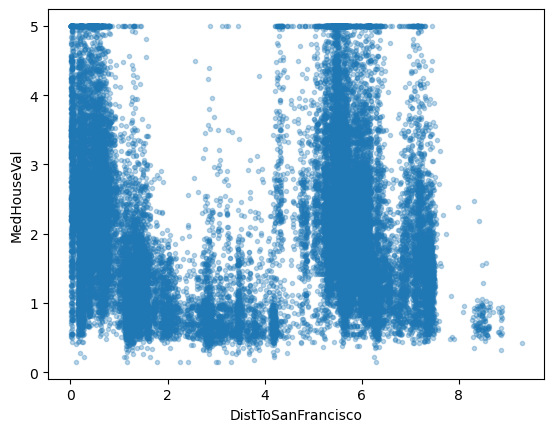

In [60]:
plt.scatter(train['DistToSanFrancisco'], train['MedHouseVal'], marker='.', alpha=0.3)
plt.ylabel('MedHouseVal')
plt.xlabel('DistToSanFrancisco')

Text(0.5, 0, 'DistToLA')

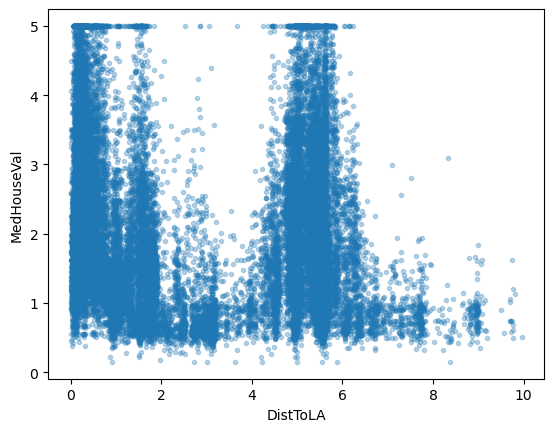

In [61]:
plt.scatter(train['DistToLA'], train['MedHouseVal'], marker='.', alpha=0.3)
plt.ylabel('MedHouseVal')
plt.xlabel('DistToLA')

In [62]:
train['DistToMajorCity'] = train['DistToSanFrancisco'].where(train['DistToSanFrancisco'] < train['DistToLA'])

Text(0.5, 0, 'DistToMajorCity')

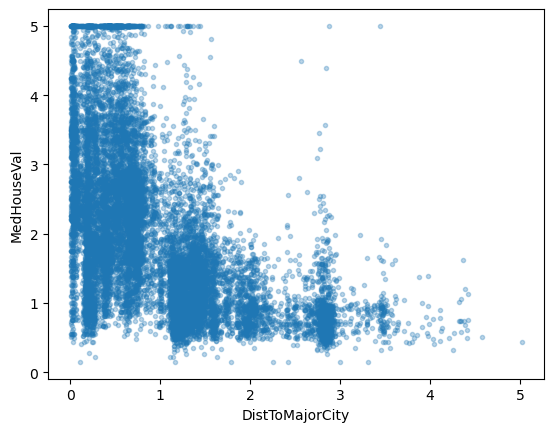

In [63]:
plt.scatter(train['DistToMajorCity'], train['MedHouseVal'], marker='.', alpha=0.3)
plt.ylabel('MedHouseVal')
plt.xlabel('DistToMajorCity')

In [64]:
train.corrwith(train['MedHouseVal']).sort_values(ascending=False)

MedHouseVal           1.000000
MedInc                0.701925
AveRooms              0.366727
HouseAge              0.103210
Population           -0.038479
DistToSanFrancisco   -0.042158
AveOccup             -0.048475
Longitude            -0.056742
AveBedrms            -0.067487
DistToLA             -0.104989
Latitude             -0.116499
DistToCoast          -0.468807
DistToMajorCity      -0.549011
dtype: float64

- Quite high negative correlation between distance to a major city and MedHouseVal
- The graph looks quite similar to distance to the coast